# Performance of Cart-Callers 

by `Xiaoli Qiu`

Created: `2022-03-30`

Jira: https://clearlink.atlassian.net/browse/ONE-8686.

<br>

This notebook gauges the performance of cart-callers. <br>
- Whether cart-callers convert better. <br>
- Is it worth adding into the current ABP. <br>
<br>

# Executive Summary
- A year of data (2021-02-01 - 2022-01-31) is used in this analysis.
- About 3-5% of the answered calls (mainly ATT and CTL) are from cart-callers.
- Cart-callers seem to have a [higher conversion rate](#conv_comp) (ATT cart-callers convert 7.8% higher than the general callers), and the conversion difference between the cart-callers and the general callers is [statistically significant](#ss_overall).
- Wheter the caller has interacted with a cart does not seem to correlate well with [conversion](#correlation), hence does not justify the need of adding it to ABP.
    - This can be explained by: cart-callers tend to (1) have a higher probability of [consent yes and intent yes](#call_ratios) and (2) come from certain channel (ppc or else). And both situations are captured in the current ABP model.

<br>

# Content
- [Cart-Callers](#CartCallers)
- [Statistical Significance - Cart-Callers](#ss_cartcallers)
    - [Statistical Significance - ATT](#ss_cartcallers_att)
- [ATT ABP Attributes](#abp)
    - [Correlation Analysis](#correlation)
    - [Intent and Consent of Cart-Callers ](#call_ratios)
- [TL;DR](#tldr)
 

In [1]:
import datetime
print('Last time updated: ', datetime.datetime.now())

Last time updated:  2022-03-30 14:02:41.075116


In [2]:
import pandas as pd

In [3]:
import researchpy
from scipy.stats import chi2_contingency 
from sklearn.feature_selection import  mutual_info_classif

In [4]:
import matplotlib.pyplot as plt  
plt.style.use('dark_background')
import seaborn as sns
%matplotlib inline

In [5]:
import psycopg2

In [6]:
f=open("/Users/xiaoli.qui/Documents/DataExplorer/DW_Credentials/DW_Credentials.txt","r")
lines=f.readlines()
username=lines[0].strip()
password=lines[1].strip()
f.close()

In [7]:
con = psycopg2.connect(dbname = 'datawarehouse', host ='dw_prod.clearlinkdata.com', 
                       port = '5439', user = username, password = password)

# con = psycopg2.connect(dbname = 'datawarehouse_stage', host ='dw_stage.clearlinkdata.com', 
#                        port = '5439', user = username, password = password)""

In [8]:
get_overall_conv = """
SELECT cd.brand_skilled,
       COUNT(DISTINCT cd.contact_id) AS count_answered_calls, 
       COUNT(DISTINCT moc.orders_id) AS count_orders,
       ROUND(ISNULL((count_orders::DECIMAL / NULLIF(count_answered_calls::DECIMAL, 0)) * 100, 0), 1) AS conversion_per_anscall
FROM data_warehouse.call_detail cd
         LEFT JOIN data_warehouse.match_orders_calls moc
                   ON cd.contact_id = moc.contact_id
                       AND moc.order_action = 'Scheduled'
WHERE cd.date_sort_prequeue_start BETWEEN '{start_date}' AND '{end_date}' 
AND cd.brand_skilled IN ('ATT', 'EMB', 'CLC', 'QWE', 'WDS')
AND cd.call_type = 'I'
AND cd.call_purpose = 'Sales'
AND cd.is_queue_opp = 1
AND cd.abandon_code = 1
GROUP BY cd.brand_skilled
;
"""

In [9]:
# Another way to identify those
get_cart_conv = """
SELECT cd.brand_skilled,
       COUNT(DISTINCT cci.interaction_type_value) AS count_carts,
       COUNT(DISTINCT cd.contact_id) AS count_answered_calls,
       COUNT(DISTINCT moc.orders_id) AS count_orders,
       ROUND(ISNULL((count_orders::DECIMAL / NULLIF(count_answered_calls::DECIMAL, 0)) * 100, 0), 1) AS conversion_per_anscall
FROM fuse_db.core_core_interactions cci
LEFT JOIN data_warehouse.cpr_invoca_call_log cicl on cci.interaction_type_value = cicl.request_id
LEFT JOIN data_warehouse.call_detail cd
                    ON cd.contact_id = cicl.contact_id
                        AND cd.call_type = 'I'
                        AND cd.call_purpose = 'Sales'
                        AND cd.is_queue_opp = 1
                        AND cd.abandon_code = 1
         LEFT JOIN data_warehouse.match_orders_calls moc
                   ON cd.contact_id = moc.contact_id
                       AND moc.order_action = 'Scheduled'
WHERE interaction_type_id = 3
AND cd.date_sort_prequeue_start BETWEEN '{start_date}' AND '{end_date}' 
AND cd.brand_skilled IN ('ATT', 'EMB', 'CLC', 'QWE', 'WDS')
GROUP BY cd.brand_skilled;
"""

In [10]:
start_date= '2021-02-01'
end_date= '2022-01-31'

In [11]:
df_overall_conv = pd.read_sql_query(get_overall_conv.format(start_date=start_date, end_date=end_date), con)
df_cart_conv = pd.read_sql_query(get_cart_conv.format(start_date=start_date, end_date=end_date), con)

<a id='conv_comp'> </a>

__Explanations of the Columns below:__ <br>
A year of data is used ('2021-02-01' - '2022-01-31'), 
- `conversion_per_anscall_cart` = # of converted cart-callers (i.e., `count_orders_cart`) / # of answered cart-callers (i.e., `count_answered_calls_cart`) for that `brand_skilled`. 
- `conversion_per_anscall_overall` = # of converted calls / # of answered calls for that `brand_skilled`. 
- `cart_callers_percent` = `count_answered_calls_cart` / `count_answered_calls_overall`. 
- `conv_diff` = `conversion_per_anscall_cart` - `conversion_per_anscall_overall`. 

In [12]:
df_merged = pd.merge(df_cart_conv, df_overall_conv, how='inner', on='brand_skilled', suffixes=['_cart', '_overall'])
df_merged['cart_callers_percent'] = round(df_merged['count_answered_calls_cart'] / df_merged['count_answered_calls_overall'], 2) * 100
df_merged['conv_diff'] = df_merged['conversion_per_anscall_cart'] - df_merged['conversion_per_anscall_overall']
df_merged[['brand_skilled', 
           'count_answered_calls_cart', 'count_orders_cart', 'conversion_per_anscall_cart', 
           'count_answered_calls_overall', 'count_orders_overall', 'conversion_per_anscall_overall', 'cart_callers_percent', 'conv_diff']].sort_values(by=['brand_skilled'])

brand_skilled  count_answered_calls_cart  count_orders_cart  \
2           ATT                       8184               3157   
1           EMB                       6633               2204   
3           QWE                       3031               1177   
0           WDS                          3                  0   

   conversion_per_anscall_cart  count_answered_calls_overall  \
2                         38.6                        227963   
1                         33.2                        253858   
3                         38.8                         65787   
0                          0.0                         22719   

   count_orders_overall  conversion_per_anscall_overall  cart_callers_percent  \
2                 70187                            30.8                   4.0   
1                 71095                            28.0                   3.0   
3                 23599                            35.9                   5.0   
0                  5052                            22.2                   0.0   

   conv_diff  
2        7.8  
1        5.2  
3        2.9  
0      -22.2

__Conclusions:__ <br>

About 3-5% of answered calls are cart-callers. Cart-callers seem to convert better (7.8% absolute percentage point for ATT). 

<a id='ss_cartcallers'> </a>

# Statistical Significance - Cart-Callers

In [13]:
get_cart_callers = """
SELECT cd.brand_skilled,
       cicl.request_id                                                cart_id,
       cd.contact_id,
       CASE WHEN COUNT(DISTINCT moc.orders_id) > 0 THEN 1 ELSE 0 END AS is_converted
FROM fuse_db.core_core_interactions cci
         LEFT JOIN data_warehouse.cpr_invoca_call_log cicl on cci.interaction_type_value = cicl.request_id
         LEFT JOIN data_warehouse.call_detail cd
                   ON cd.contact_id = cicl.contact_id
                       AND cd.call_type = 'I'
                       AND cd.call_purpose = 'Sales'
                       AND cd.is_queue_opp = 1
                       AND cd.abandon_code = 1
         LEFT JOIN data_warehouse.match_orders_calls moc
                   ON cd.contact_id = moc.contact_id
                       AND moc.order_action = 'Scheduled'
WHERE interaction_type_id = 3
AND cd.date_sort_prequeue_start BETWEEN '{start_date}' AND '{end_date}'
AND cd.brand_skilled IN ('ATT', 'EMB', 'CLC', 'QWE', 'WDS')
GROUP BY cd.brand_skilled, cicl.request_id, cd.contact_id
;
"""

In [14]:
get_all_callers = """
SELECT cd.brand_skilled,
       cd.contact_id,
       CASE WHEN COUNT(DISTINCT moc.orders_id) > 0 THEN 1 ELSE 0 END AS is_converted
FROM data_warehouse.call_detail cd
         LEFT JOIN data_warehouse.match_orders_calls moc
                   ON cd.contact_id = moc.contact_id
                       AND moc.order_action = 'Scheduled'
WHERE cd.date_sort_prequeue_start BETWEEN '{start_date}' AND '{end_date}'
AND cd.brand_skilled IN ('ATT', 'EMB', 'CLC', 'QWE', 'WDS')
AND cd.call_type = 'I'
AND cd.call_purpose = 'Sales'
AND cd.is_queue_opp = 1
AND cd.abandon_code = 1
GROUP BY cd.brand_skilled, cd.contact_id
;
"""

In [15]:
df_cart_callers = pd.read_sql_query(get_cart_callers.format(start_date=start_date, end_date=end_date), con)
df_all_callers = pd.read_sql_query(get_all_callers.format(start_date=start_date, end_date=end_date), con)

In [16]:
cart_conv = df_cart_callers.rename(columns={'is_converted': 'cart_conversion'})
all_conv = df_all_callers.rename(columns={'is_converted': 'all_conversion'})

des, res = researchpy.ttest(cart_conv['cart_conversion'], all_conv['all_conversion'])

In [17]:
des

Variable         N      Mean        SD        SE  95% Conf.  \
0  cart_conversion   17851.0  0.360596  0.480187  0.003594   0.353551   
1   all_conversion  922847.0  0.316842  0.465246  0.000484   0.315893   
2         combined  940698.0  0.317673  0.465572  0.000480   0.316732   

   Interval  
0  0.367641  
1  0.317792  
2  0.318613

In [18]:
res

Independent t-test      results
0  Difference (cart_conversion - all_conversion) =        0.0438
1                             Degrees of freedom =   940696.0000
2                                              t =       12.4375
3                          Two side test p value =        0.0000
4                         Difference < 0 p value =        1.0000
5                         Difference > 0 p value =        0.0000
6                                      Cohen's d =        0.0940
7                                      Hedge's g =        0.0940
8                                  Glass's delta =        0.0911
9                                    Pearson's r =        0.0128

<a id='ss_overall'> </a>

__Observations:__ <br>

For all the brands retrieved (brand_skilled IN ('ATT', 'EMB', 'CLC', 'QWE', 'WDS')), cart-callers's conversion is higher by __4.38%__ than the overall answered calls. And this difference is not by chance and it's statistically significant. 

<a id='ss_cartcallers_att'> </a> 

## Statistical Significance - ATT

In [19]:
# ATT
cart_conv_att = df_cart_callers[df_cart_callers['brand_skilled']=='ATT'].rename(columns={'is_converted': 'cart_conversion'})
all_conv_att = df_all_callers[df_all_callers['brand_skilled']=='ATT'].rename(columns={'is_converted': 'all_conversion'})

des_att, res_att = researchpy.ttest(cart_conv_att['cart_conversion'], all_conv_att['all_conversion'])
des_att

Variable         N      Mean        SD        SE  95% Conf.  \
0  cart_conversion    8184.0  0.382331  0.485987  0.005372   0.371801   
1   all_conversion  227963.0  0.304054  0.460007  0.000963   0.302165   
2         combined  236147.0  0.306767  0.461153  0.000949   0.304907   

   Interval  
0  0.392862  
1  0.305942  
2  0.308627

In [20]:
res_att

Independent t-test      results
0  Difference (cart_conversion - all_conversion) =        0.0783
1                             Degrees of freedom =   236145.0000
2                                              t =       15.0947
3                          Two side test p value =        0.0000
4                         Difference < 0 p value =        1.0000
5                         Difference > 0 p value =        0.0000
6                                      Cohen's d =        0.1698
7                                      Hedge's g =        0.1698
8                                  Glass's delta =        0.1611
9                                    Pearson's r =        0.0310

__Observations:__ <br>

ATT cart-callers's conversion is higher than the general ATT callers by 7.8% and the difference is statistically significant (p value < 0.05 `Difference > 0 p value =`).


<a id='abp'> </a>

# ATT ABP Attributes

Look at the correlation analysis of ATT the ABP attributes, as well cart-callers. 


In [21]:
get_conv_training_set = """
SELECT date_prequeue, contact_id, brand_skilled, intent_lookup_flag, consent_flag, 
    CASE WHEN channel = 'Pay Per Click' THEN 1 ELSE 0 END       AS channel_is_ppc, marketing_tier, 
    is_weekday, max_speed_qual, is_converted
FROM data_warehouse.call_detail_attribute_log
WHERE brand_skilled IN {brands_skilled} 
AND date_prequeue >= '{train_start_date}'
AND date_prequeue <= '{train_end_date}'
AND max_speed_qual in {valid_speeds}
AND call_conclusion = 'Answered'
ORDER BY 1;
"""

get_cartcaller_cd = """
SELECT cd.brand_skilled,
       cicl.request_id                                                cart_id,
       cd.contact_id
FROM fuse_db.core_core_interactions cci
         INNER JOIN data_warehouse.cpr_invoca_call_log cicl on cci.interaction_type_value = cicl.request_id
         LEFT JOIN data_warehouse.call_detail cd
                   ON cd.contact_id = cicl.contact_id
                       AND cd.call_type = 'I'
                       AND cd.call_purpose = 'Sales'
                       AND cd.is_queue_opp = 1
                       AND cd.abandon_code = 1
         LEFT JOIN data_warehouse.match_orders_calls moc
                   ON cd.contact_id = moc.contact_id
                       AND moc.order_action = 'Scheduled'
WHERE interaction_type_id = 3
AND cd.date_sort_prequeue_start BETWEEN '{start_date}' AND '{end_date}'
AND cd.brand_skilled IN ('ATT')
;
"""

In [22]:
def process_training_set(train_set):
    """
    Function to build rows for the training set
    :param train_set: training set data frame
    :return: processed row training set
    """
    train_set.loc[:, 'marketing_tier'] = 'NA'

    train_set.rename(columns={'marketing_tier': 'marketing_tier_group'}, inplace=True)

    cols = ['intent_lookup_flag', 'consent_flag', 'channel_is_ppc',
            'marketing_tier_group', 'max_speed_qual', 'is_weekday']

    for c in cols:
        train_set[c] = train_set[c].astype('category')


    train_set = train_set.sort_values('is_converted', ascending=False).drop_duplicates(subset=['contact_id'],
                                                                                       keep="first")
    train_set.dropna(subset=['marketing_tier_group'], inplace=True)

    to_drop = ['date_prequeue', 'brand_skilled', 'contact_id']
    train_set.drop(to_drop, axis=1, inplace=True)
    return train_set


In [23]:
def chi_square_test(df):
    """
    Function for performing chi-square test.
    :param df: targe dataframe
    :return: (1) chi-square values in dataframe and (2) p-values in dataframe. The columns names and index are the same. 
    """
    cols = list(df.columns)
    resultant_p = pd.DataFrame(data=[(0 for i in range(len(cols))) for i in range(len(cols))], 
                         columns=cols)
    resultant_p.set_index(pd.Index(cols), inplace = True)
    resultant_chi = resultant_p.copy(deep=True)

    # Finding p_value for all columns and putting them in the resultant matrix
    for i in cols:
        for j in cols:
            if i != j:
                chi2_val, p_val, _, _ = chi2_contingency(pd.crosstab(df[i], df[j]))
#                 chi2_val, p_val = chi2(np.array(df[i]).reshape(-1, 1), np.array(df[j]).reshape(-1, 1))
                resultant_p.loc[i,j] = p_val
                resultant_chi.loc[i,j] = chi2_val
                
    return tuple([resultant_chi, resultant_p])


In [24]:
valid_sq_speeds = [5000, 1000, 75, 50, 18, 10, 25, 100, 5, 2, 1, 0]
revenue_limit = [20, 600]
brand_skilled = ['ATT']
cur_date = '2022-02-28'

max_valid_speeds = "({valid_speeds}, 'NA')".format(valid_speeds=', '.join(map(str, ["'{x}'".format(x=x) for x in valid_sq_speeds])))
brands_skilled ="({skilled})".format(skilled=", ".join("'" + item + "'" for item in brand_skilled))

In [25]:
train_set_conv = pd.read_sql(get_conv_training_set.format(train_start_date=start_date, train_end_date=end_date, valid_speeds=max_valid_speeds, brands_skilled=brands_skilled), con)

In [26]:
df_cart_callers_d = pd.read_sql_query(get_cartcaller_cd.format(start_date=start_date, end_date=end_date), con)

In [27]:
train_set_conv['cartcaller_flag'] = 0
train_set_conv.loc[train_set_conv['contact_id'].astype(int).isin(df_cart_callers_d['contact_id'].unique()), 'cartcaller_flag'] = 1

In [28]:
train_set_conv_processed = process_training_set(train_set_conv)

In [29]:
[resultant_chi_2, resultant_p_2] = chi_square_test(train_set_conv_processed[['intent_lookup_flag', 'consent_flag', 'max_speed_qual', 'is_weekday', 'channel_is_ppc', 'cartcaller_flag', 'is_converted']])

<a id='correlation'> </a>

## Correlation Analysis

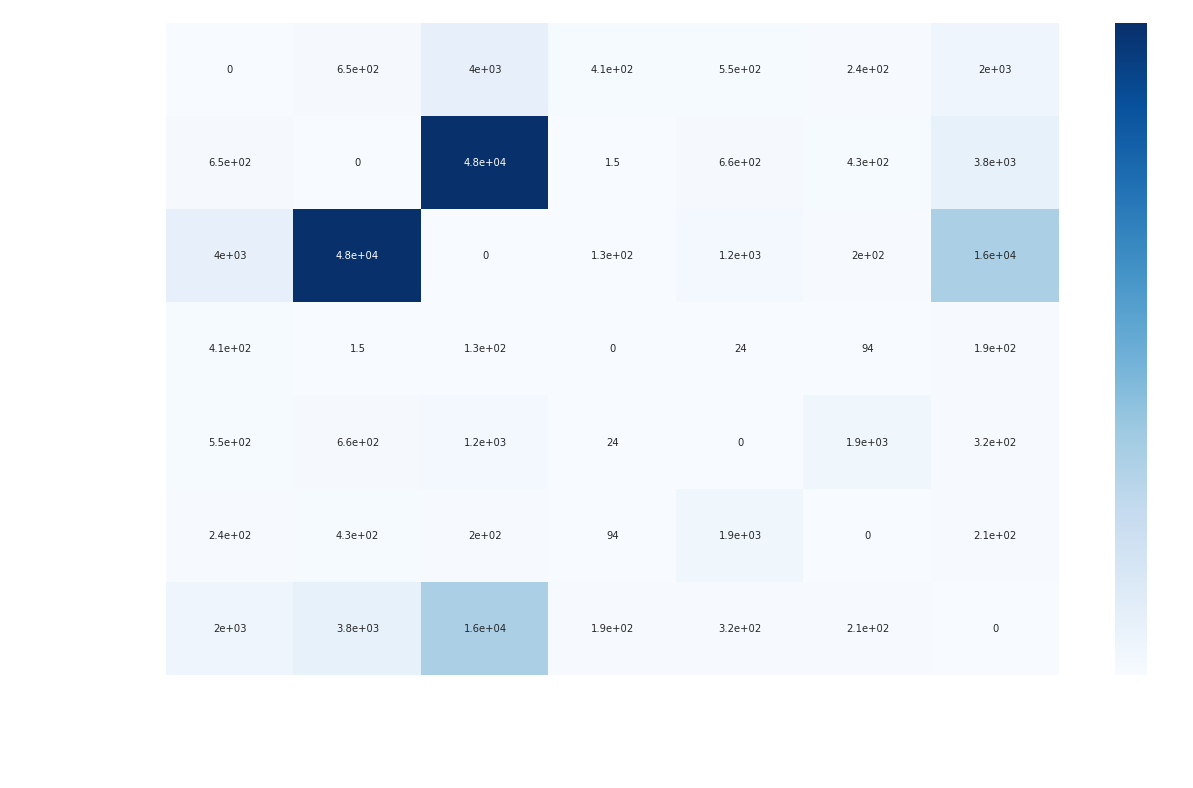

In [30]:
# Plotting chi-square values
bfig = plt.figure(figsize=(20,12))
g = sns.heatmap(resultant_chi_2, annot=True, cmap='Blues')
g.set_xticklabels(g.get_xticklabels(), rotation = 30, fontsize = 18)
g.set_yticklabels(g.get_yticklabels(), rotation = 30, fontsize = 18)
plt.title('Chi-Square Test chi')
plt.show()

__Observations:__ <br>

`cartcaller_flag` indicates whether the call has a cart interaction associated with it. <br>

In the plot above, the larger the number is, the higher the probability of two variables being dependent is, i.e., correlated. <br>

`cartcaller_flag` has a higher correlation with `channel_is_ppc` and `consent_flag` compared to `is_converted`. 

In [31]:
train_set_conv_processed.replace({'NA': -1}, inplace=True)
independentvars = train_set_conv_processed[['intent_lookup_flag', 'consent_flag', 'max_speed_qual', 'is_weekday', 'channel_is_ppc', 'cartcaller_flag']]
mutual_info = mutual_info_classif(independentvars, train_set_conv_processed['is_converted'])

mutual_info = pd.Series(mutual_info)
mutual_info.index = independentvars.columns
mutual_info.sort_values(ascending=False)

/Users/xiaoli.qui/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


max_speed_qual        0.042895
consent_flag          0.024753
is_weekday            0.019369
intent_lookup_flag    0.015716
channel_is_ppc        0.014227
cartcaller_flag       0.001784
dtype: float64

__Observations:__ <br>

Similar conclusion using information theory, i.e., `cartcaller_flag` correlates bettter with `channel_is_ppc` and `consent_flag` than to `is_converted`.

In [32]:
# A look at the intent and consent for cart-callers
cart_callers_conv = train_set_conv[train_set_conv['cartcaller_flag']==1].groupby(by=['intent_lookup_flag', 'consent_flag']).agg({'contact_id': lambda x:x.nunique(), 'is_converted':'sum'}).reset_index()
cart_callers_conv['conversion'] = round(cart_callers_conv['is_converted'] / cart_callers_conv['contact_id'], 4)
cart_callers_conv['call_ratio'] = cart_callers_conv['contact_id']/cart_callers_conv['contact_id'].sum()
cart_callers_conv.sort_values(by=['call_ratio'], ascending=[False])

intent_lookup_flag consent_flag  contact_id  is_converted  conversion  \
3                  1            1        4047          2219      0.5483   
5                  2            1        1893           687      0.3629   
2                  1            0         704           255      0.3622   
4                  2            0         348            61      0.1753   
1                  0            1         118            36      0.3051   
0                  0            0          19             3      0.1579   

   call_ratio  
3    0.567681  
5    0.265535  
2    0.098752  
4    0.048815  
1    0.016552  
0    0.002665

In [33]:
# A look at the intent and consent for non-cart-callers
ncart_callers_conv = train_set_conv[train_set_conv['cartcaller_flag']==0].groupby(by=['intent_lookup_flag', 'consent_flag']).agg({'contact_id': lambda x:x.nunique(), 'is_converted':'sum'}).reset_index()
ncart_callers_conv['conversion'] = round(ncart_callers_conv['is_converted'] / ncart_callers_conv['contact_id'], 4)
ncart_callers_conv['call_ratio'] = ncart_callers_conv['contact_id']/ncart_callers_conv['contact_id'].sum()
ncart_callers_conv.sort_values(by=['call_ratio'], ascending=[False])

intent_lookup_flag consent_flag  contact_id  is_converted  conversion  \
3                  1            1       77947         38418      0.4929   
5                  2            1       47212         17274      0.3659   
2                  1            0       30239          8924      0.2951   
4                  2            0       13411          2451      0.1828   
1                  0            1        7768          2764      0.3558   
0                  0            0        2769           226      0.0816   

   call_ratio  
3    0.434618  
5    0.263245  
2    0.168607  
4    0.074777  
1    0.043313  
0    0.015439

<a id='call_ratios'> </a>

## Intent and Consent of Cart-Callers 

Comparing the intent and consent for cart-callers to the non-cart-callers. 

The column names with a suffix of `_cart` indicates the cart-callers.
The column names with a suffix of `_noncart` indicates the non-cart-callers.

The column names with a prefix of `call_ratio` indicates the percentage of calls in that buckekt (combination of intent and consent). 

In [34]:
comp = pd.merge(cart_callers_conv[['intent_lookup_flag', 'consent_flag', 'conversion', 'call_ratio']], 
                ncart_callers_conv[['intent_lookup_flag', 'consent_flag', 'conversion', 'call_ratio']], 
                on=['intent_lookup_flag', 'consent_flag'], how='inner', suffixes=['_cart', '_noncart'])
comp.sort_values(by=['consent_flag', 'intent_lookup_flag'], ascending=[False, False])

intent_lookup_flag consent_flag  conversion_cart  call_ratio_cart  \
5                  2            1           0.3629         0.265535   
3                  1            1           0.5483         0.567681   
1                  0            1           0.3051         0.016552   
4                  2            0           0.1753         0.048815   
2                  1            0           0.3622         0.098752   
0                  0            0           0.1579         0.002665   

   conversion_noncart  call_ratio_noncart  
5              0.3659            0.263245  
3              0.4929            0.434618  
1              0.3558            0.043313  
4              0.1828            0.074777  
2              0.2951            0.168607  
0              0.0816            0.015439

In [35]:
comp.groupby(by=['consent_flag']).agg({'call_ratio_cart': 'sum', 'call_ratio_noncart':'sum'})

call_ratio_cart  call_ratio_noncart
consent_flag                                     
0                    0.150231            0.258824
1                    0.849769            0.741176

In [36]:
comp.groupby(by=['intent_lookup_flag']).agg({'call_ratio_cart': 'sum', 'call_ratio_noncart':'sum'})

call_ratio_cart  call_ratio_noncart
intent_lookup_flag                                     
0                          0.019217            0.058752
1                          0.666433            0.603225
2                          0.314350            0.338023

__Observations:__ <br>

Cart-Callers seem to have a higher consent yes, and a slightly higher intent yes as well.

<a id='tldr'> </a>

# TL;DR

- Abount 3-5% of the answered calls are from cart-callers.
- Cart-callers seem to have a [higher conversion rate](#conv_comp) (ATT cart-callers convert 7.8% higher than the general callers), and it is [statistically significant](#ss_overall).
- However, any value by adding a flag for cart-callers into ABP is already captured by other ABP attributes like [consent, intent and channel](#call_ratios)